In [10]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import TextVectorization, Normalization  # Example for preprocessing layers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


print(tf.__version__)

2.18.0


In [14]:
dataset = {
             "train_data" : "D:/python/data/train",
             "valid_data" : "D:/python/data/valid",
             "test_data" : "D:/python/data/test"
          }

all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)
        
        
    all_data.append(data.copy())
    data.clear()

    
    
train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))
test_df = pd.DataFrame(all_data[2] , index=range(len(all_data[2]['imgpath'])))


# #Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])
test_df['encoded_labels'] = lb.fit_transform(test_df['labels'])

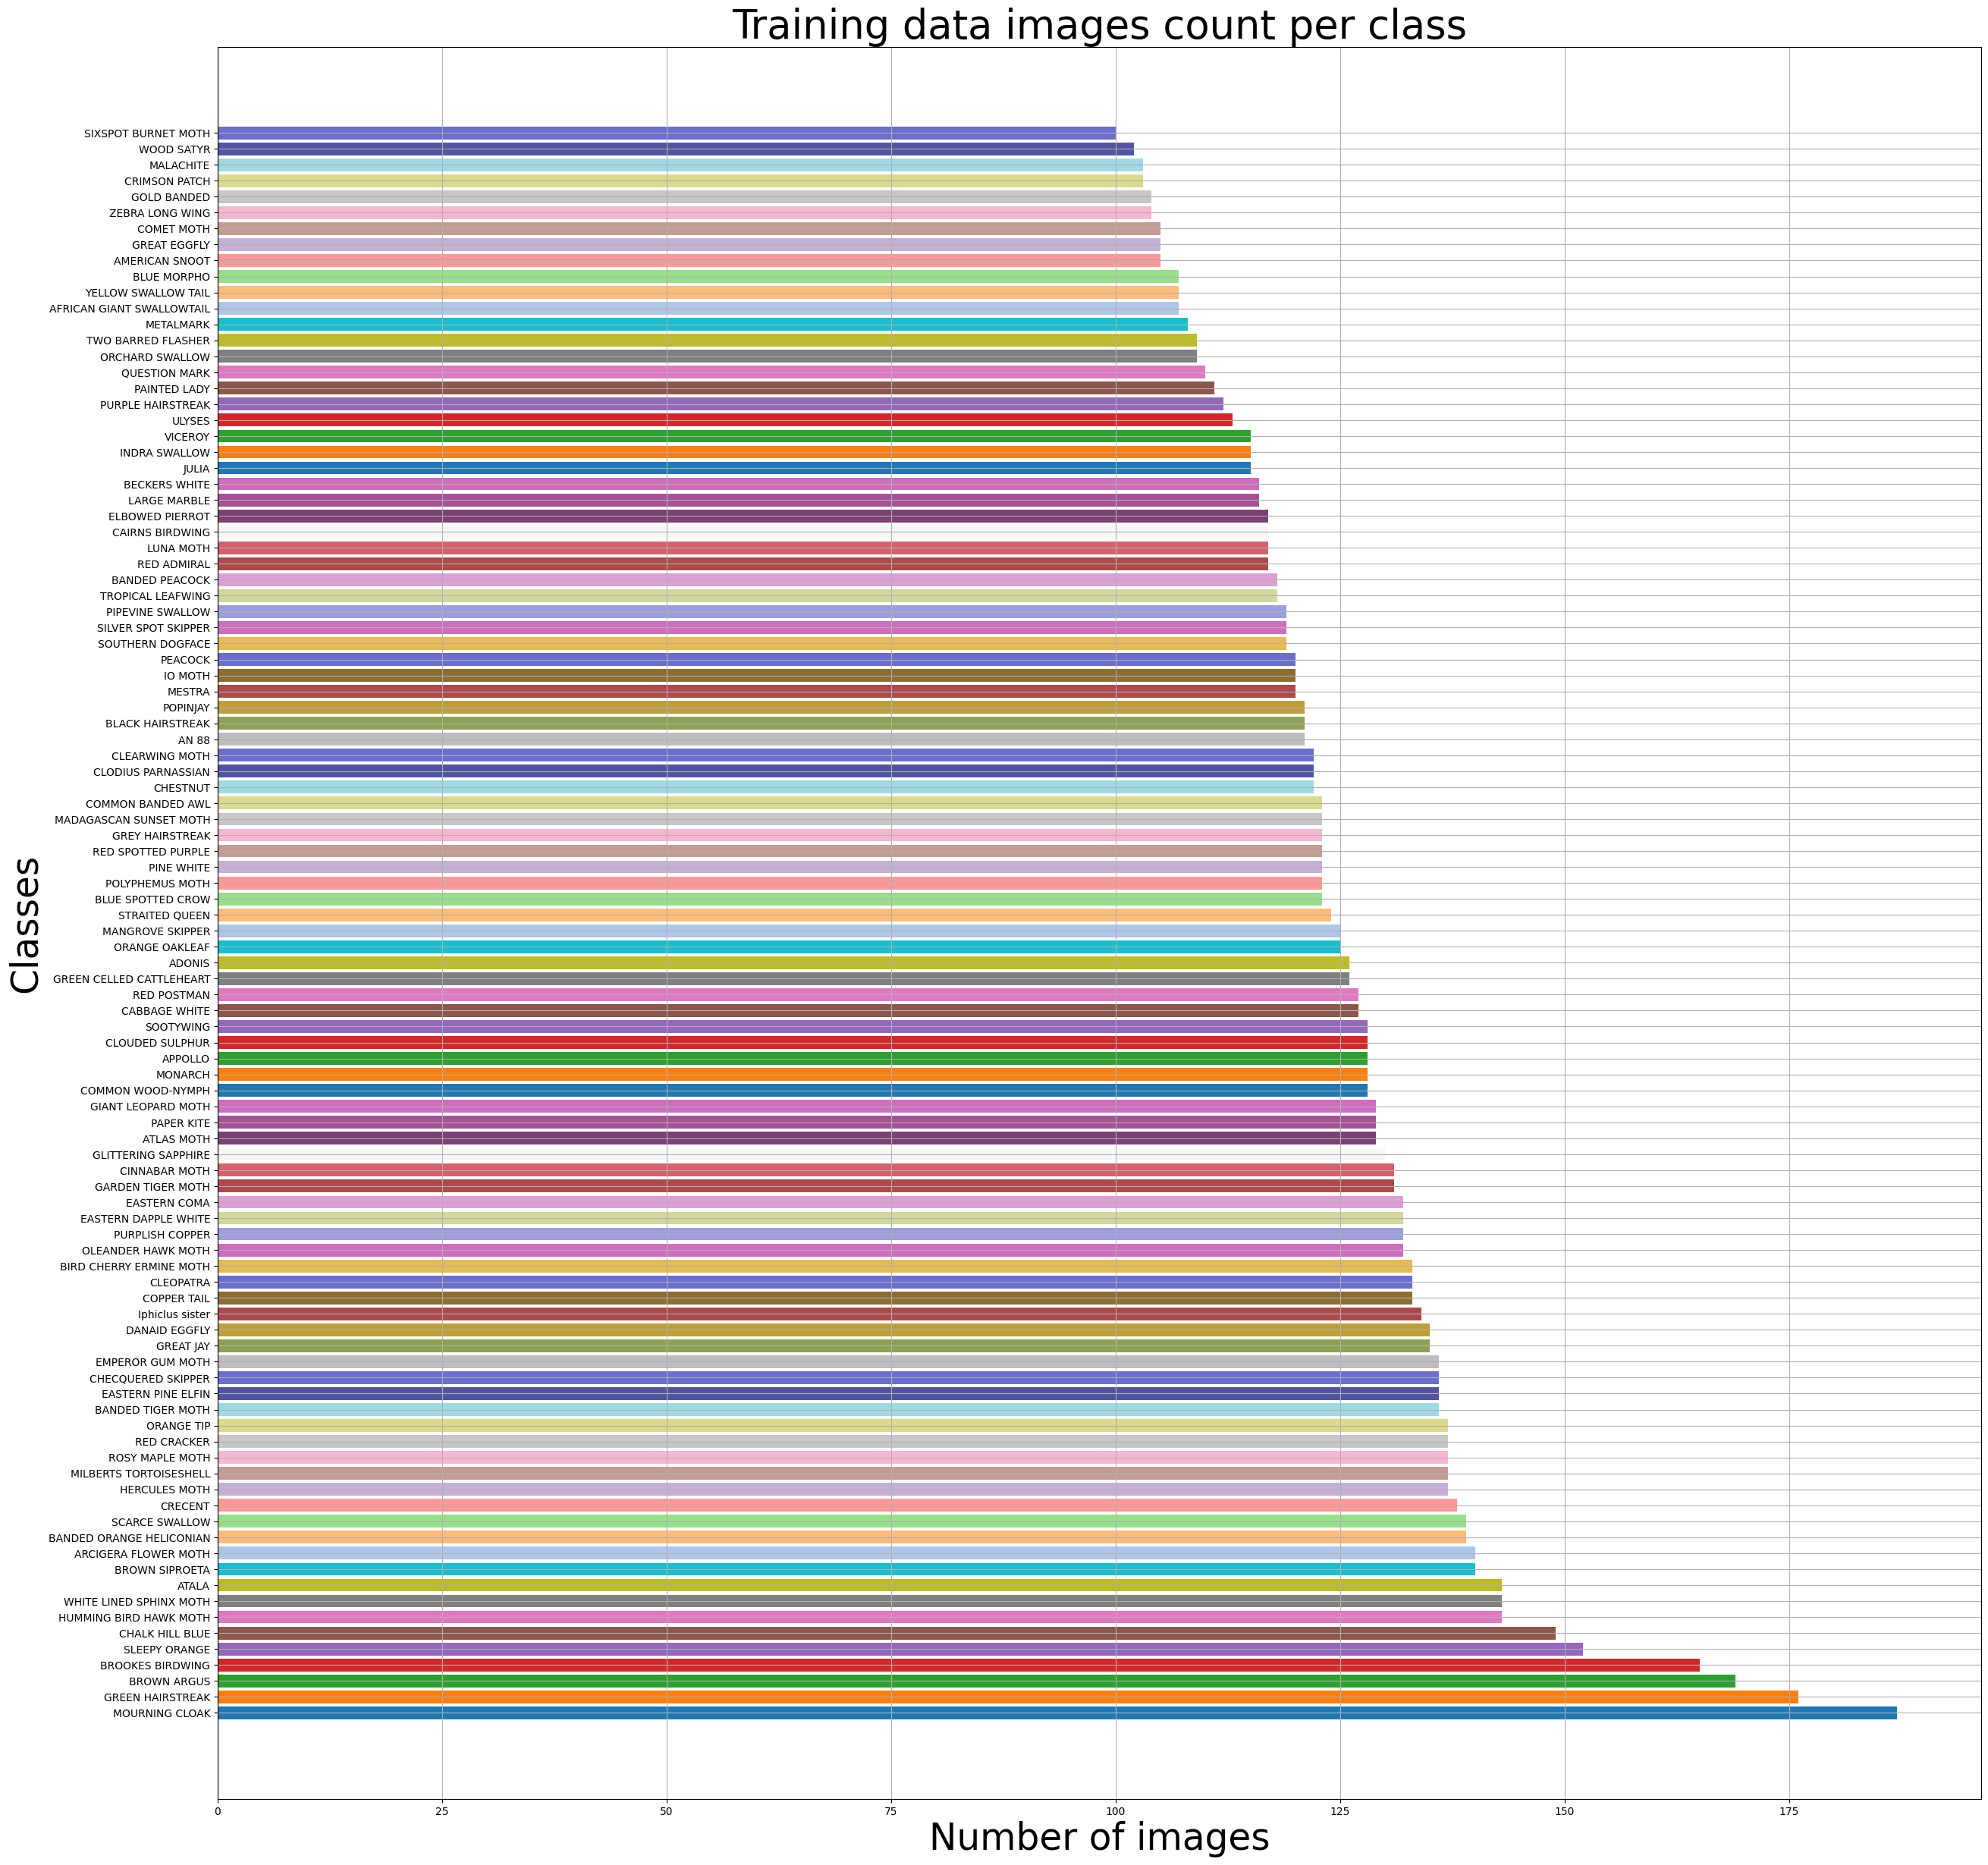

In [15]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(30,30))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()

In [16]:
train_df.sample(n=15, random_state=1)

imgpath               labels  \
9560      D:/python/data/train\PIPEVINE SWALLOW\117.jpg     PIPEVINE SWALLOW   
12398  D:/python/data/train\YELLOW SWALLOW TAIL\016.jpg  YELLOW SWALLOW TAIL   
6228      D:/python/data/train\GREEN HAIRSTREAK\098.jpg     GREEN HAIRSTREAK   
4204           D:/python/data/train\COPPER TAIL\096.jpg          COPPER TAIL   
4021     D:/python/data/train\COMMON WOOD-NYMPH\041.jpg    COMMON WOOD-NYMPH   
11789    D:/python/data/train\TROPICAL LEAFWING\107.jpg    TROPICAL LEAFWING   
854                  D:/python/data/train\ATALA\128.jpg                ATALA   
9661       D:/python/data/train\POLYPHEMUS MOTH\099.jpg      POLYPHEMUS MOTH   
7760      D:/python/data/train\MANGROVE SKIPPER\108.jpg     MANGROVE SKIPPER   
1332     D:/python/data/train\BANDED TIGER MOTH\077.jpg    BANDED TIGER MOTH   
6872               D:/python/data/train\IO MOTH\048.jpg              IO MOTH   
4580         D:/python/data/train\DANAID EGGFLY\098.jpg        DANAID EGGFLY   
5489    D:/python/data/train\GIANT LEOPARD MOTH\088.jpg   GIANT LEOPARD MOTH   
10351          D:/python/data/train\RED CRACKER\074.jpg          RED CRACKER   
749                  D:/python/data/train\ATALA\023.jpg                ATALA   

       encoded_labels  
9560               74  
12398              98  
6228               48  
4204               32  
4021               31  
11789              92  
854                 6  
9661               75  
7760               60  
1332               10  
6872               53  
4580               35  
5489               42  
10351              81  
749                 6

In [17]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                               imgpath  labels
0  D:/python/data/train\ADONIS\001.jpg  ADONIS
1  D:/python/data/train\ADONIS\002.jpg  ADONIS
2  D:/python/data/train\ADONIS\003.jpg  ADONIS
3  D:/python/data/train\ADONIS\004.jpg  ADONIS
4  D:/python/data/train\ADONIS\005.jpg  ADONIS
(12594, 3)
--------Validation----------
                             imgpath  labels
0  D:/python/data/valid\ADONIS\1.jpg  ADONIS
1  D:/python/data/valid\ADONIS\2.jpg  ADONIS
2  D:/python/data/valid\ADONIS\3.jpg  ADONIS
3  D:/python/data/valid\ADONIS\4.jpg  ADONIS
4  D:/python/data/valid\ADONIS\5.jpg  ADONIS
(500, 3)
----------Test--------------
                            imgpath  labels
0  D:/python/data/test\ADONIS\1.jpg  ADONIS
1  D:/python/data/test\ADONIS\2.jpg  ADONIS
2  D:/python/data/test\ADONIS\3.jpg  ADONIS
3  D:/python/data/test\ADONIS\4.jpg  ADONIS
4  D:/python/data/test\ADONIS\5.jpg  ADONIS
(500, 3)


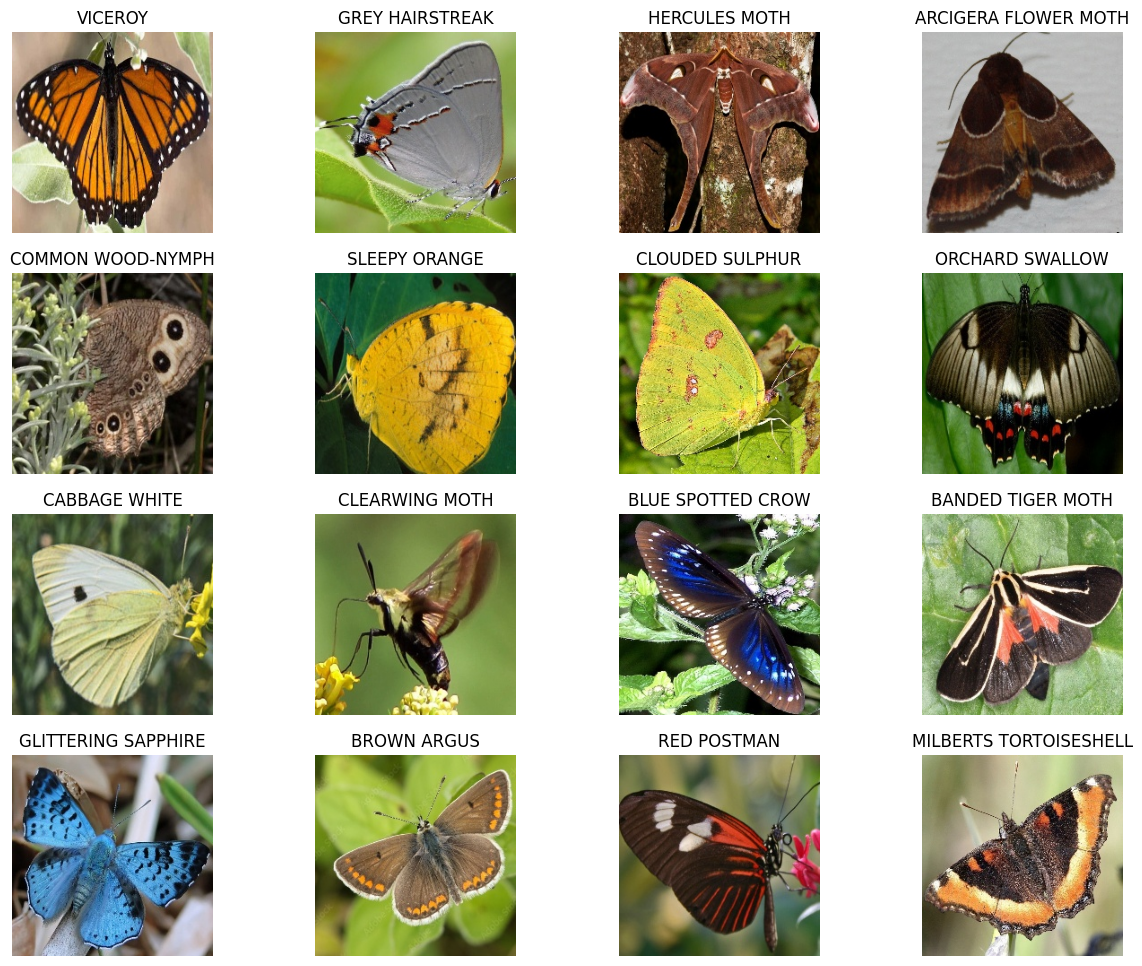

In [18]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [19]:
%%time

BATCH_SIZE = 25
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 12594 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.
CPU times: total: 984 ms
Wall time: 984 ms


In [20]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [48]:
from tensorflow.keras import layers  # Ensure this import exists

# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),           # Horizontal Flip
    layers.RandomRotation(0.13),               # Random Rotation
    layers.RandomZoom(0.12),                   # Random Zoom
    layers.RandomContrast(0.10),               # Random Contrast
], name='AugmentationLayer')

inputs = layers.Input(shape=(224, 224, 3), name='inputLayer')
x = augment(inputs)

pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x) 
x = BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_5 (Cast)                   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AugmentationLayer (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_6 (Cast)                   │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activationLayer (Activation)    │ (None, 100)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,404,231 (16.80 MB)

 Trainable params: 354,148 (1.35 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

None


In [33]:
inputs = layers.Input(shape=(128, 128, 3))  # Change size to 128x128


In [37]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=5,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint.h5')  # Add .h5 extension


Epoch 1/5
  2/504 ━━━━━━━━━━━━━━━━━━━━ 19:20 2s/step - accuracy: 0.9500 - loss: 0.1934

KeyboardInterrupt: 

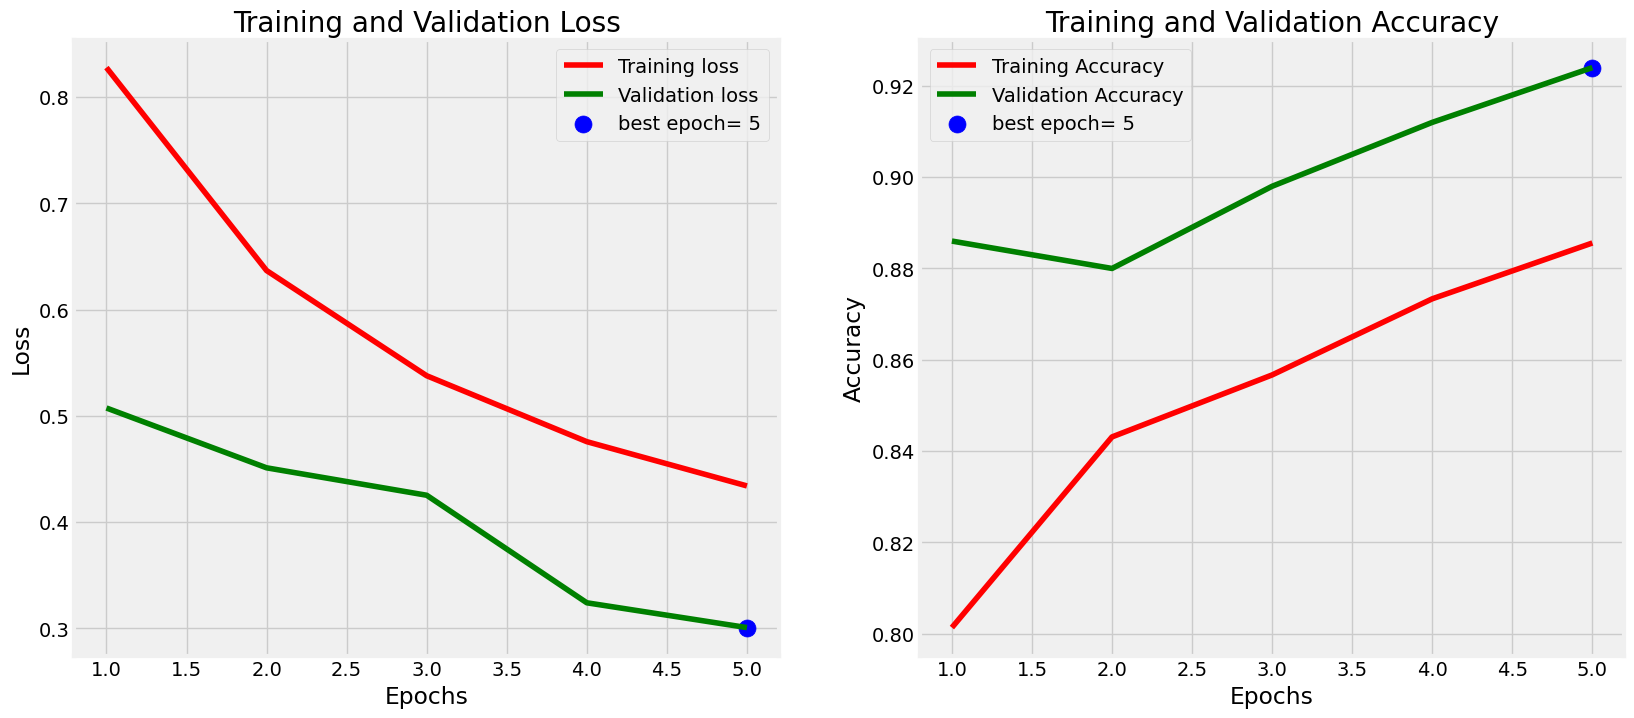

In [38]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [39]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False
        
# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=45,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

input_layer False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_3 (Cast)                   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AugmentationLayer (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_4 (Cast)                   │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activationLayer (Activation)    │ (None, 100)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,404,231 (16.80 MB)

 Trainable params: 354,148 (1.35 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

None
Epoch 1/45
504/504 ━━━━━━━━━━━━━━━━━━━━ 1079s 2s/step - accuracy: 0.8981 - loss: 0.3920 - val_accuracy: 0.9260 - val_loss: 0.2805 - learning_rate: 1.0000e-05
Epoch 2/45
504/504 ━━━━━━━━━━━━━━━━━━━━ 1024s 2s/step - accuracy: 0.9084 - loss: 0.3560 - val_accuracy: 0.9300 - val_loss: 0.2720 - learning_rate: 1.0000e-05
Epoch 3/45
504/504 ━━━━━━━━━━━━━━━━━━━━ 1044s 2s/step - accuracy: 0.9035 - loss: 0.3541 - val_accuracy: 0.9340 - val_loss: 0.2691 - learning_rate: 1.0000e-05
Epoch 4/45
504/504 ━━━━━━━━━━━━━━━━━━━━ 1034s 2s/step - accuracy: 0.9104 - loss: 0.3380 - val_accuracy: 0.9320 - val_loss: 0.2665 - learning_rate: 1.0000e-05
Epoch 5/45
504/504 ━━━━━━━━━━━━━━━━━━━━ 1034s 2s/step - accuracy: 0.9093 - loss: 0.3461 - val_accuracy: 0.9380 - val_loss: 0.2639 - learning_rate: 1.0000e-05
Epoch 6/45
504/504 ━━━━━━━━━━━━━━━━━━━━ 995s 2s/step - accuracy: 0.9082 - loss: 0.3375 - val_accuracy: 0.9360 - val_loss: 0.2630 - learning_rate: 1.0000e-05
Epoch 7/45
 22/504 ━━━━━━━━━━━━━━━━━━━━ 18:25 2s

KeyboardInterrupt: 

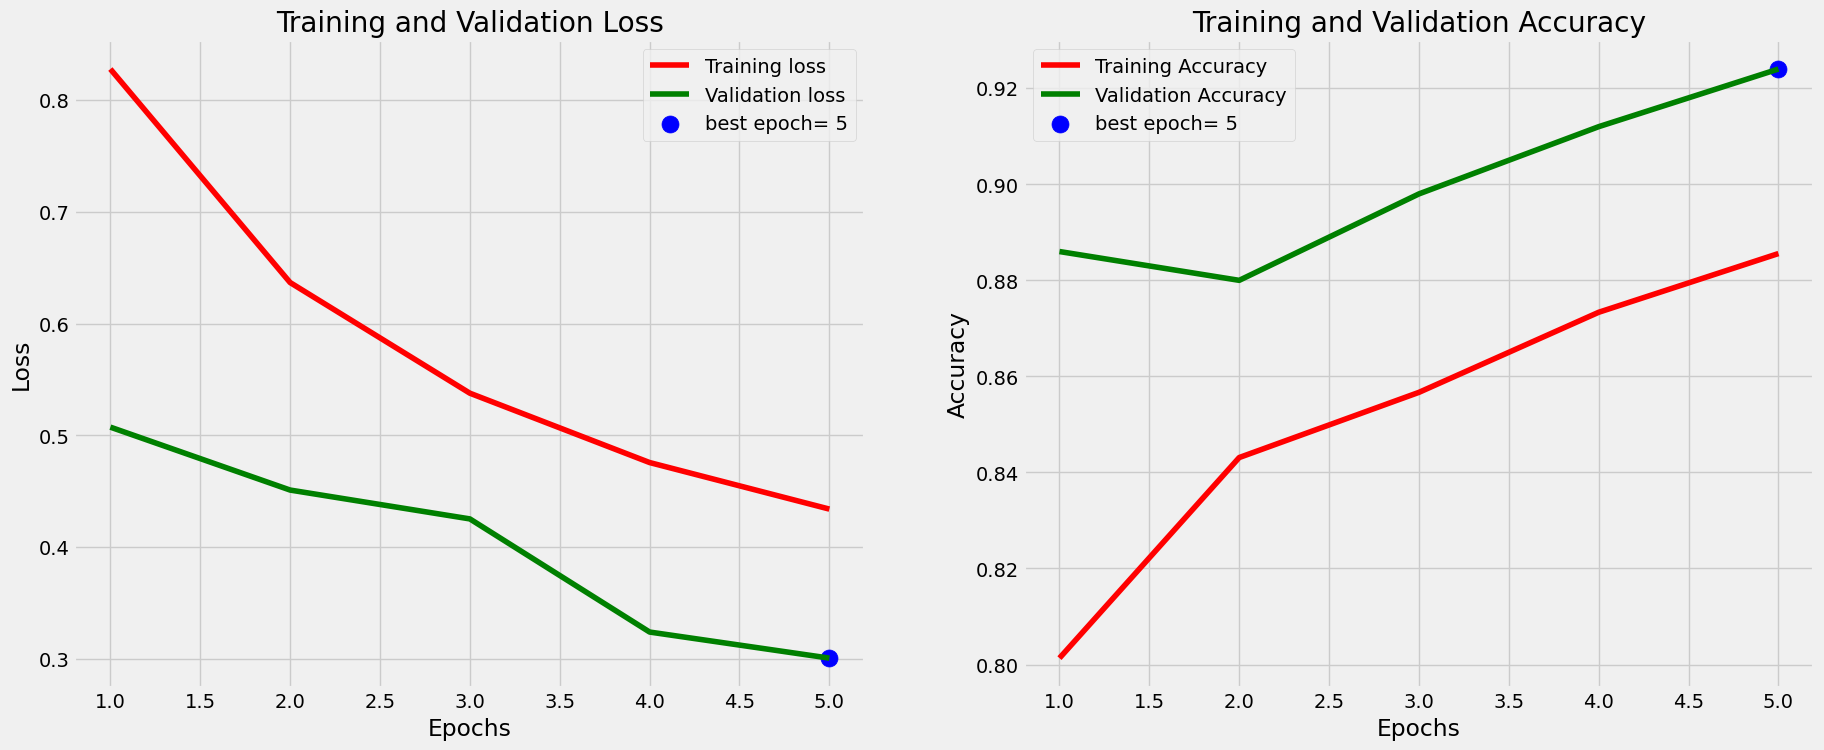

In [40]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [41]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.21923
Test Accuracy: 94.20%


In [42]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step
F1 Score: 0.9411277056277055
                           precision    recall  f1-score   support

                   ADONIS       1.00      0.80      0.89         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      1.00      1.00         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       1.00      1.00      1.00         5
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
                    ATALA       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      0.80      0.89         5
            BECKERS WHITE       1.00      0.60      0.75         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00    

In [43]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))), 
                            "Test Labels" : test_images.labels, 
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step


Image Index  Test Labels               Test Classes  Prediction Labels  \
0            0            0                     ADONIS                  0   
1            1            0                     ADONIS                  0   
2            2            0                     ADONIS                  0   
3            3            0                     ADONIS                  0   
4            4            0                     ADONIS                 21   
5            5            1  AFRICAN GIANT SWALLOWTAIL                  1   
6            6            1  AFRICAN GIANT SWALLOWTAIL                  1   
7            7            1  AFRICAN GIANT SWALLOWTAIL                  1   

          Prediction Classes  \
0                     ADONIS   
1                     ADONIS   
2                     ADONIS   
3                     ADONIS   
4            CHALK HILL BLUE   
5  AFRICAN GIANT SWALLOWTAIL   
6  AFRICAN GIANT SWALLOWTAIL   
7  AFRICAN GIANT SWALLOWTAIL   

                                                Path  Prediction Probability  
0                   D:/python/data/test\ADONIS\1.jpg                0.600184  
1                   D:/python/data/test\ADONIS\2.jpg                0.712707  
2                   D:/python/data/test\ADONIS\3.jpg                0.922115  
3                   D:/python/data/test\ADONIS\4.jpg                0.913881  
4                   D:/python/data/test\ADONIS\5.jpg                0.500275  
5  D:/python/data/test\AFRICAN GIANT SWALLOWTAIL\...                0.992550  
6  D:/python/data/test\AFRICAN GIANT SWALLOWTAIL\...                0.997875  
7  D:/python/data/test\AFRICAN GIANT SWALLOWTAIL\...                0.999517

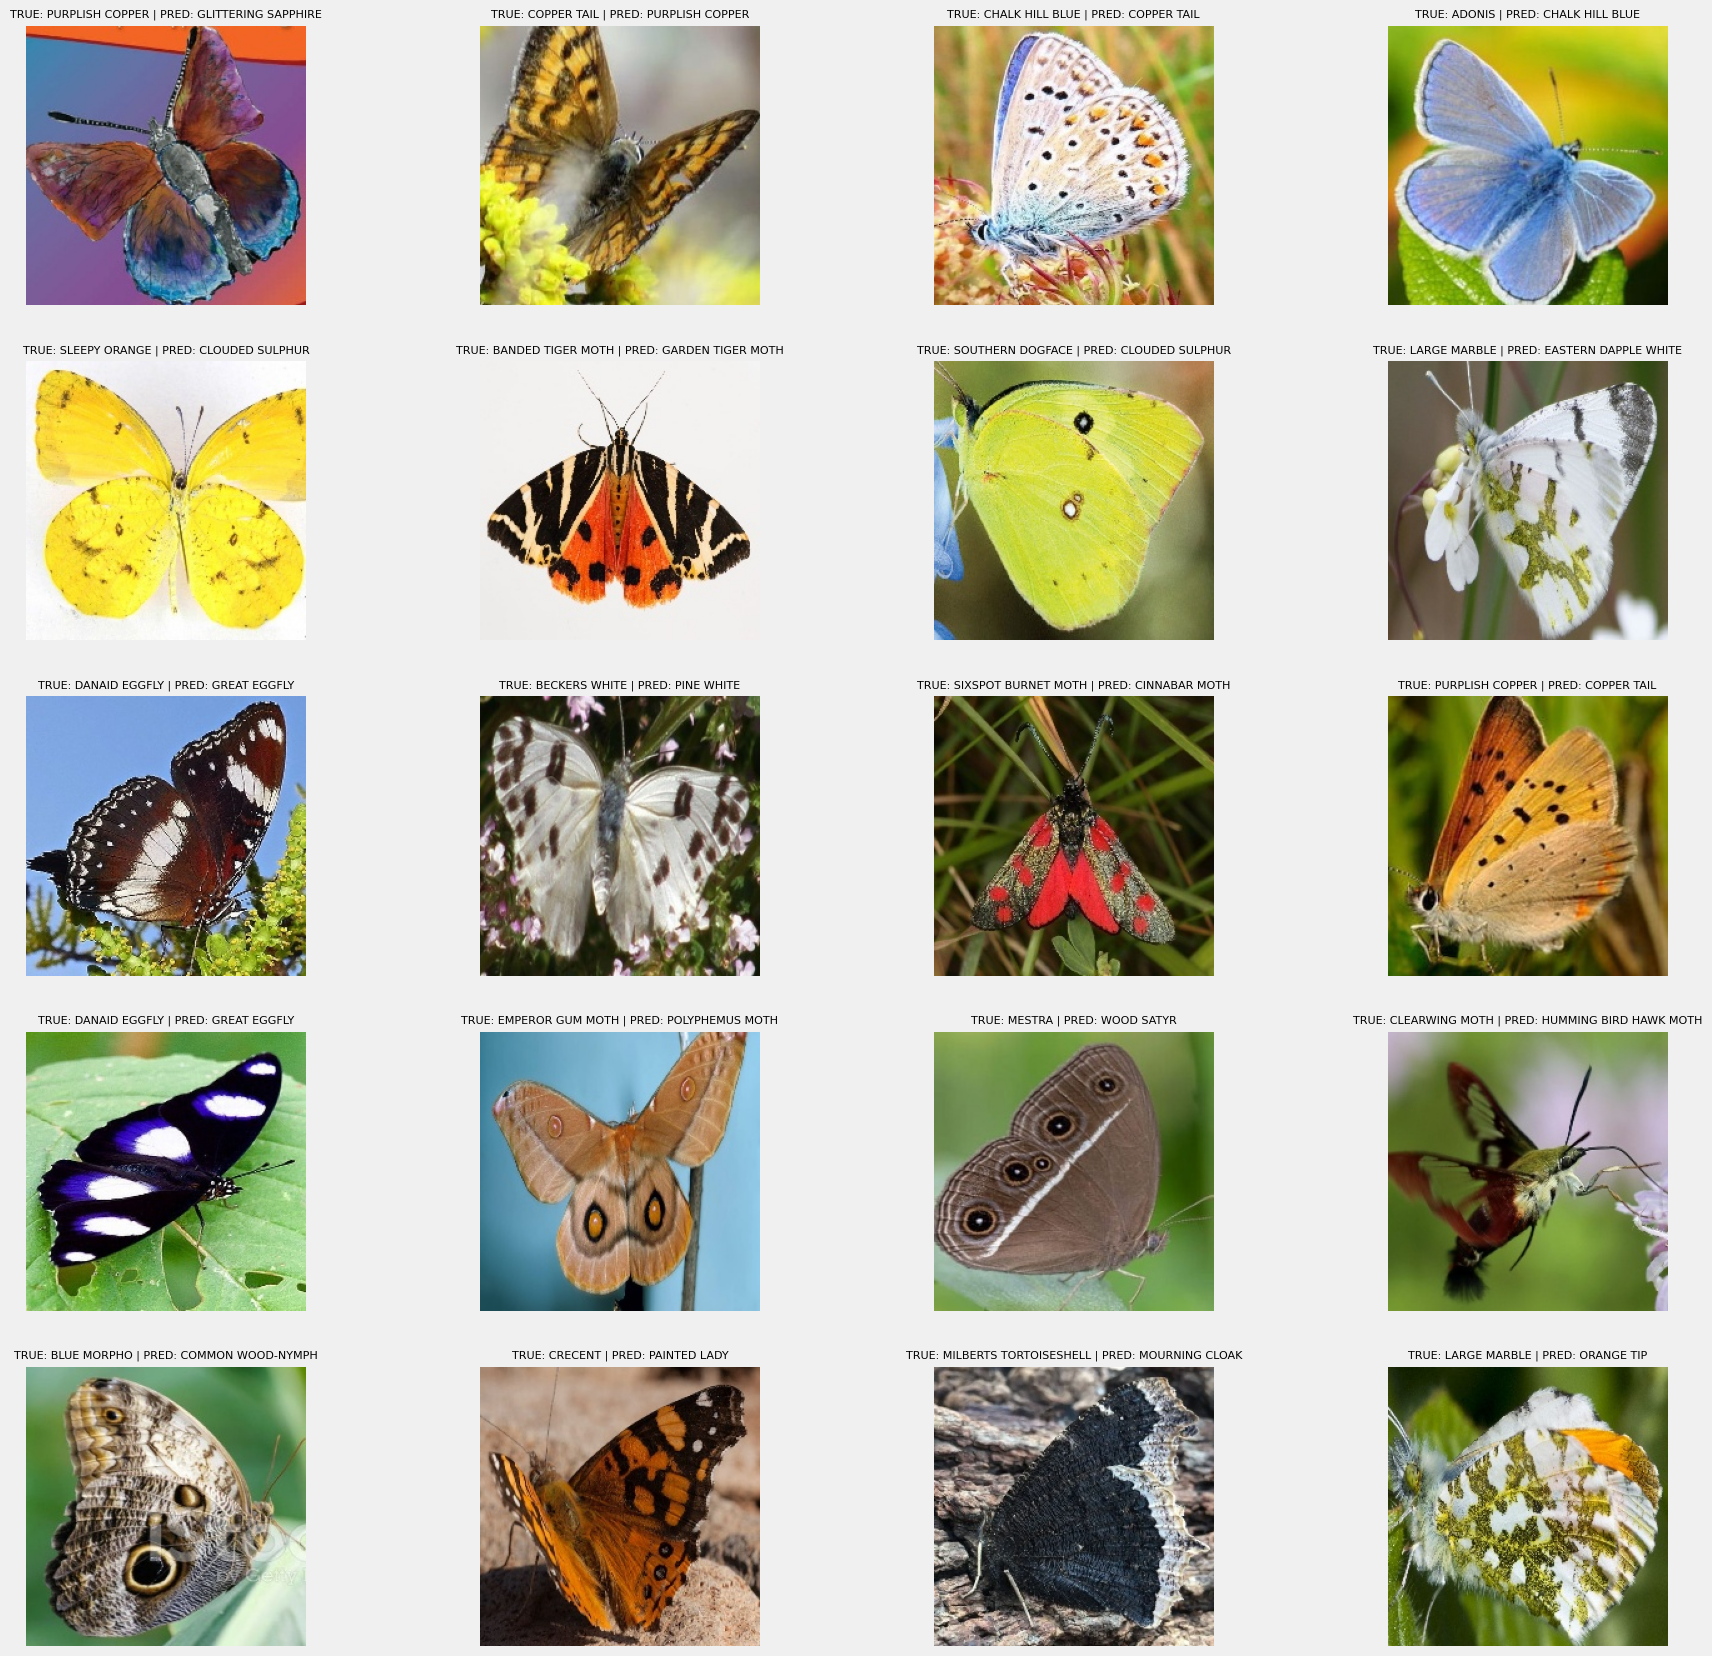

In [44]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')
    
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step


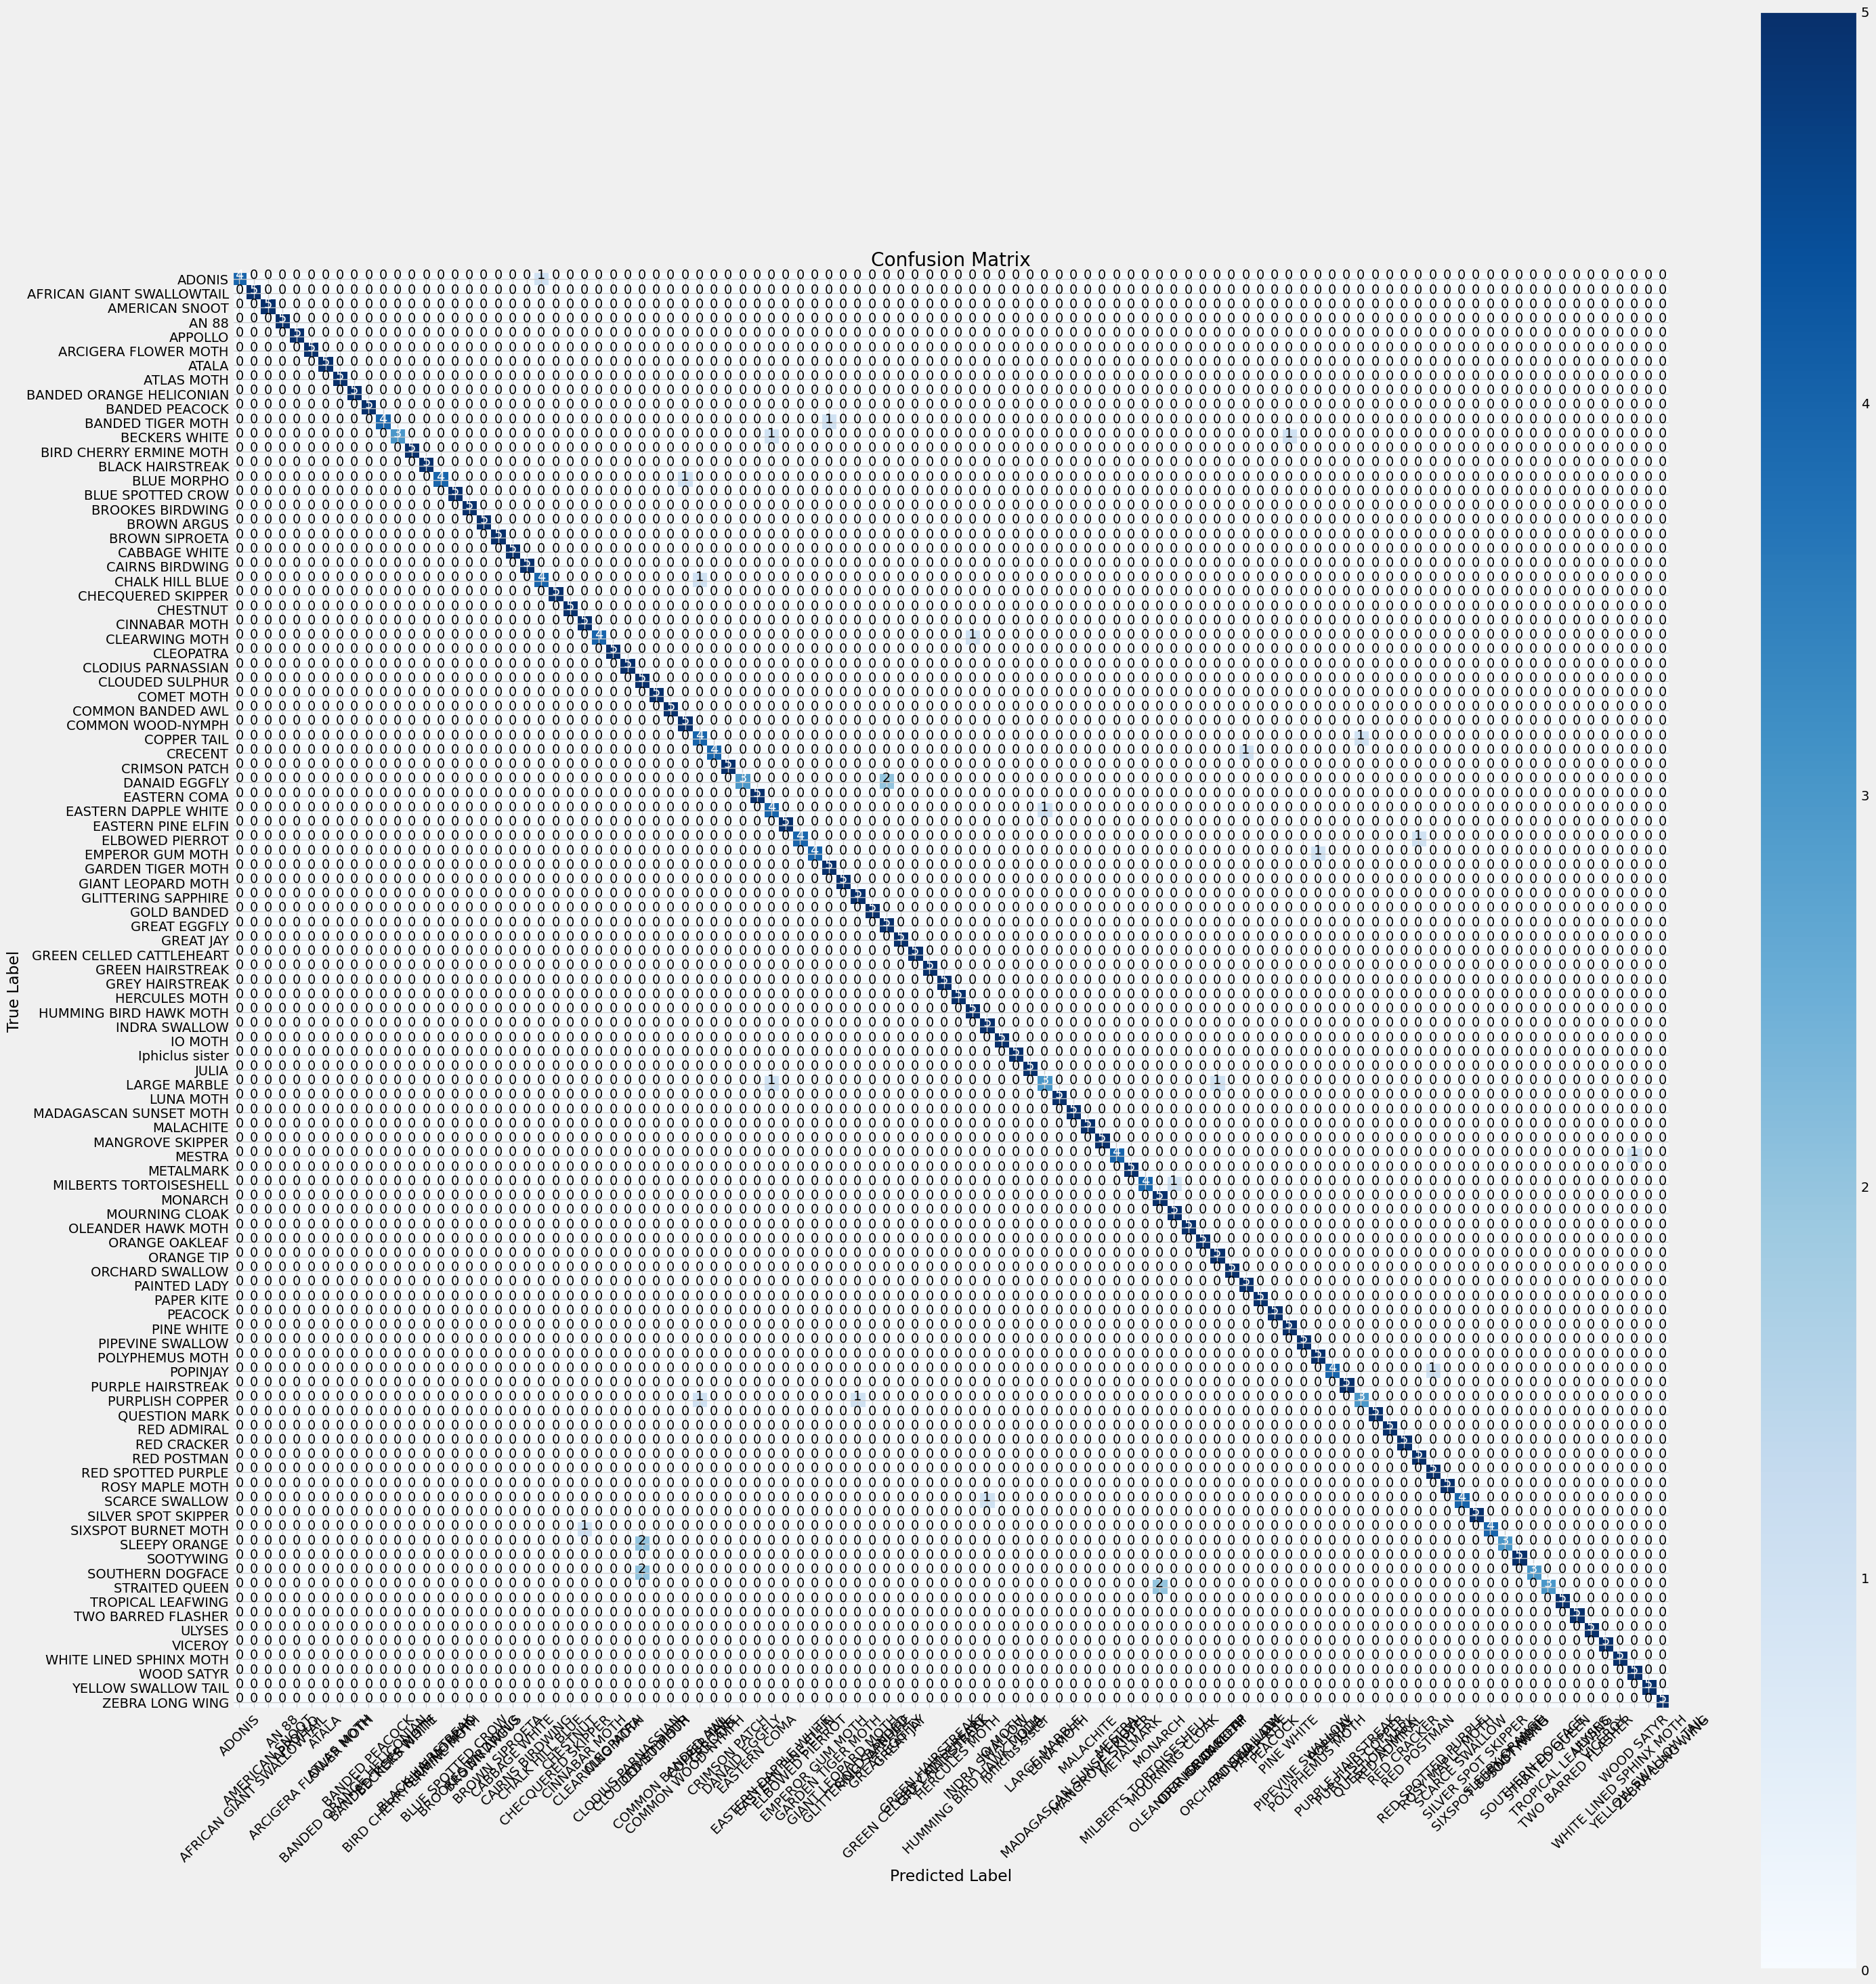

In [46]:
preds = model.predict(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [47]:
model.save('model/model.h5')


In [1]:
import os

# Paths to dataset directories
train_dir = 'D:/python/data/train'
test_dir = 'D:/python/data/test'
val_dir = 'D:/python/data/valid'

# Function to count images in a directory
def count_images(directory):
    total_images = 0
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            total_images += len([f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))])
    return total_images

# Count images
num_train_images = count_images(train_dir)
num_test_images = count_images(test_dir)
num_val_images = count_images(val_dir)

# Print results
print(f"Number of training images: {num_train_images}")
print(f"Number of test images: {num_test_images}")
print(f"Number of validation images: {num_val_images}")


Number of training images: 12594
Number of test images: 500
Number of validation images: 500
